In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split



from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import confusion_matrix , classification_report
from tensorflow import keras
import shap

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

In [2]:
data = pd.read_csv('Normalised_NBA_Real_HalfTime_Data.csv')

data.head()

,WL,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,...,2P_PCT,PPM,POSSESSIONS,PTSperP,EFGPCT,PACE,HOME,Scoring_Opportunities,Defensive_Index,TO_to_AST_Ratio
0,0,0.636364,0.666667,0.800000,0.420,0.444444,0.56250,0.400,0.304348,0.357143,...,0.500,0.633188,0.805556,0.319452,0.403715,0.805333,1,0.666667,0.633333,0.666667
1,1,0.509091,0.428571,0.885714,0.345,0.000000,0.00000,0.286,0.347826,0.392857,...,0.358,0.506550,0.694444,0.295203,0.115300,0.694667,1,0.333333,0.333333,0.642857
2,0,0.381818,0.428571,0.542857,0.442,0.277778,0.46875,0.294,0.260870,0.214286,...,0.538,0.379913,0.583333,0.266737,0.346244,0.583333,1,0.285714,0.500000,0.571429
3,1,0.545455,0.571429,0.514286,0.524,0.444444,0.50000,0.444,0.260870,0.535714,...,0.583,0.545852,0.555556,0.387454,0.524140,0.555333,0,0.500000,0.400000,0.538462
4,1,0.454545,0.428571,0.771429,0.373,0.277778,0.71875,0.200,0.434783,0.464286,...,0.538,0.454148,0.805556,0.219821,0.229046,0.805333,1,0.833333,0.533333,0.692308


In [3]:
# Spliting the data into training and testing sets:
X = data.drop('WL', axis=1)
y = data['WL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1110, 31), (278, 31), (1110,), (278,))

In [20]:
# Define the model function
def create_model(learning_rate=0.0001):
    model = keras.Sequential([
        keras.layers.Dense(16, input_shape=(X_train.shape[1],), activation='relu'),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'precision', 'recall', 'AUC'])
    return model

# Wrap the model using KerasClassifier
model = KerasClassifier(model=create_model, verbose=0)

# Define the hyperparameter grid
param_grid = {
    'model__learning_rate': [0.0001, 0.001, 0.01],
    'batch_size': [8, 16, 32, 64],
    'epochs': [10, 25, 50, 100]
}

# Set up GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')

# Fit the grid search
grid_result = grid.fit(X_train, y_train)

# Get the best parameters and the best score
print("Best Hyperparameters:", grid_result.best_params_)
print("Best Accuracy:", grid_result.best_score_)     

c:\Users\thoma\anaconda3\envs\conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\thoma\anaconda3\envs\conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\thoma\anaconda3\envs\conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regulariz

Best Hyperparameters: {'batch_size': 64, 'epochs': 50, 'model__learning_rate': 0.01}
Best Accuracy: 0.718018018018018


In [21]:
# Evaluate the best model on the test set
model = grid_result.best_estimator_.model_

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.7230215827338129
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.77      0.74       144
           1       0.73      0.67      0.70       134

    accuracy                           0.72       278
   macro avg       0.72      0.72      0.72       278
weighted avg       0.72      0.72      0.72       278



In [22]:
model.evaluate(X_test, y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8143 - accuracy: 0.7351 - loss: 0.5351 - precision: 0.7299 - recall: 0.7006  


[0.5612435936927795,
 0.7230215668678284,
 0.7317073345184326,
 0.6716417670249939,
 0.7839707732200623]

In [23]:
yp = model.predict(X_test)
yp[:10]

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


array([[0.9641453 ],
       [0.2774869 ],
       [0.35923418],
       [0.14062008],
       [0.3284471 ],
       [0.59689665],
       [0.34006506],
       [0.7653734 ],
       [0.39334255],
       [0.9859809 ]], dtype=float32)

In [24]:
y_pred = []
for element in yp:
    if element >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
y_pred[:10]

[1, 0, 0, 0, 0, 1, 0, 1, 0, 1]

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.77      0.74       144
           1       0.73      0.67      0.70       134

    accuracy                           0.72       278
   macro avg       0.72      0.72      0.72       278
weighted avg       0.72      0.72      0.72       278



Text(95.72222222222221, 0.5, 'Truths')

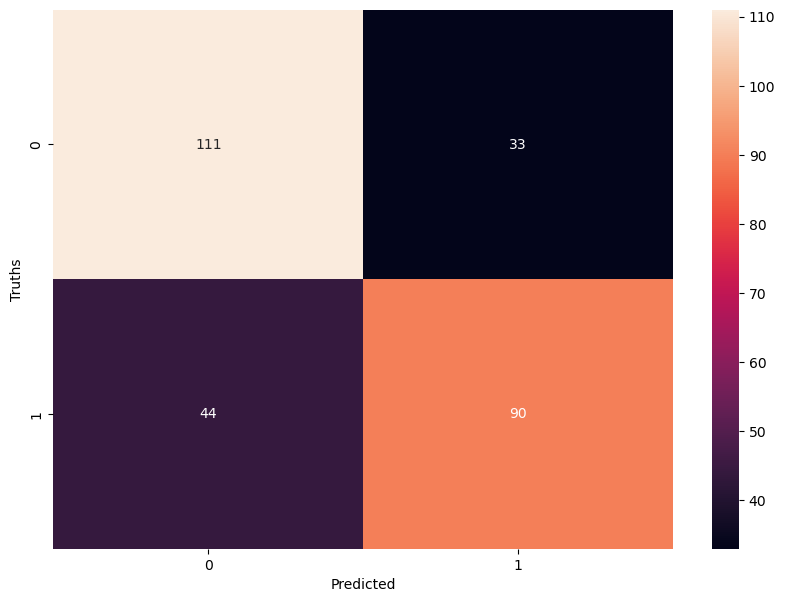

In [26]:
cm = tf.math.confusion_matrix(labels = y_test , predictions= y_pred)
plt.figure(figsize= (10 , 7))
sns.heatmap(cm , annot=True , fmt= 'd')
plt.xlabel("Predicted")
plt.ylabel("Truths")

c:\Users\thoma\anaconda3\envs\conda\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


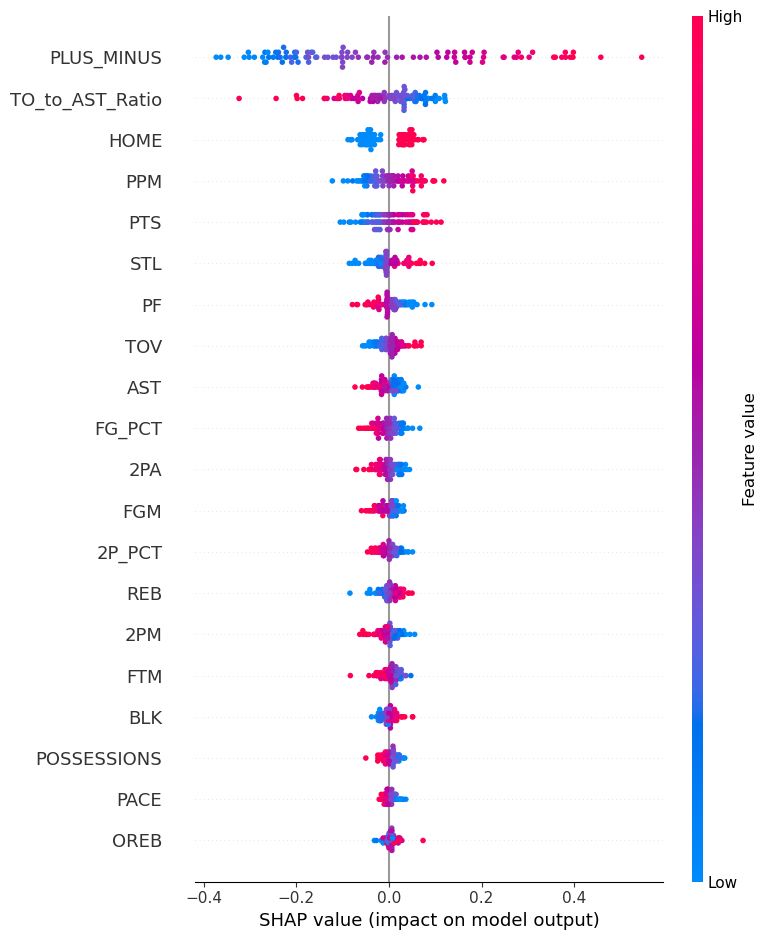

TypeError: Object of type EagerTensor is not JSON serializable

In [27]:
# Ensure feature_names matches the column order in X_train
feature_names = X_train.columns.tolist()



# SHAP Analysis
from tqdm import tqdm
import shap
# Function to make predictions
# Function to make predictions and ensure NumPy array outputs
def model_predict(X):
    return model.predict(X).flatten().astype(float)  # Ensure output is NumPy array


# Ensure X_test is in the correct format
if isinstance(X_test, pd.DataFrame):
    X_test_array = X_test.values  # Convert to NumPy array if it's a DataFrame
else:
    X_test_array = X_test  # Already a NumPy array

# Select background data for SHAP
if isinstance(X_train, pd.DataFrame):
    background_data = X_train.sample(100, random_state=42).values
else:
    background_data = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# Initialize SHAP explainer
explainer = shap.DeepExplainer(model, background_data)

# Ensure all SHAP inputs are NumPy arrays
if isinstance(X_test, pd.DataFrame):
    X_test_array = X_test.values  # Convert DataFrame to NumPy array
else:
    X_test_array = X_test

# Generate SHAP values for all rows in X_test_array[:100]
shap_values = explainer.shap_values(X_test_array[:100])

# If shap_values is a list, extract the first element
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# Reshape SHAP values to remove any extra dimensions
shap_values = shap_values.squeeze()  # Converts shape (100, 28, 1) to (100, 28)

# Visualize SHAP results
shap.summary_plot(shap_values, X_test_array[:100], feature_names=feature_names)

# Ensure NumPy arrays for force plot
shap.force_plot(
    explainer.expected_value[0], 
    shap_values[0], 
    X_test_array[0], 
    feature_names=feature_names
)

In [5]:
# Reduction of Dataset to match the SHAP values in the model:

reduced_data = data[["WL","PLUS_MINUS", "TO_to_AST_Ratio", "HOME", "PPM", "PTS", "STL", "PF", "TOV", "AST", "FG_PCT", "2PA", "FGM",
                     "2P_PCT", "REB", "2PM"]]

reduced_data.head()

,WL,PLUS_MINUS,TO_to_AST_Ratio,HOME,PPM,PTS,STL,PF,TOV,AST,FG_PCT,2PA,FGM,2P_PCT,REB,2PM
0,0,0.585366,0.666667,1,0.633188,0.636364,0.615385,0.500000,0.611111,0.666667,0.420,0.522727,0.666667,0.500,0.692308,0.521739
1,1,0.414634,0.642857,1,0.506550,0.509091,0.384615,0.333333,0.444444,0.476190,0.345,1.000000,0.428571,0.358,0.538462,0.652174
2,0,0.390244,0.571429,1,0.379913,0.381818,0.307692,0.444444,0.388889,0.476190,0.442,0.386364,0.428571,0.538,0.346154,0.434783
3,1,0.609756,0.538462,0,0.545852,0.545455,0.384615,0.277778,0.333333,0.428571,0.524,0.340909,0.571429,0.583,0.423077,0.434783
4,1,0.548780,0.692308,1,0.454148,0.454545,0.692308,0.777778,0.444444,0.428571,0.373,0.386364,0.428571,0.538,0.500000,0.434783


In [6]:
X = reduced_data.drop('WL', axis=1)
y = reduced_data['WL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape 

((1110, 15), (278, 15), (1110,), (278,))

In [8]:
# Define the model function
def create_model(learning_rate=0.0001):
    model = keras.Sequential([
        keras.layers.Dense(16, input_shape=(X_train.shape[1],), activation='relu'),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'precision', 'recall', 'AUC'])
    return model

# Wrap the model using KerasClassifier
model = KerasClassifier(model=create_model, verbose=0)

# Define the hyperparameter grid
param_grid = {
    'model__learning_rate': [0.0001, 0.001, 0.01],
    'batch_size': [8, 16, 32, 64],
    'epochs': [10, 25, 50, 100]
}

# Set up GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')

# Fit the grid search
grid_result = grid.fit(X_train, y_train)

# Get the best parameters and the best score
print("Best Hyperparameters:", grid_result.best_params_)
print("Best Accuracy:", grid_result.best_score_)     

c:\Users\thoma\anaconda3\envs\conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\thoma\anaconda3\envs\conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\thoma\anaconda3\envs\conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regulariz

c:\Users\thoma\anaconda3\envs\conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


c:\Users\thoma\anaconda3\envs\conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\thoma\anaconda3\envs\conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\thoma\anaconda3\envs\conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regulariz

Best Hyperparameters: {'batch_size': 64, 'epochs': 50, 'model__learning_rate': 0.01}
Best Accuracy: 0.7153153153153152


In [9]:
# Evaluate the best model on the test set
model = grid_result.best_estimator_.model_

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.7230215827338129
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.76      0.74       144
           1       0.72      0.69      0.70       134

    accuracy                           0.72       278
   macro avg       0.72      0.72      0.72       278
weighted avg       0.72      0.72      0.72       278



In [10]:
model.evaluate(X_test, y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8027 - accuracy: 0.7311 - loss: 0.5374 - precision: 0.7283 - recall: 0.6903  


[0.5535703301429749,
 0.7230215668678284,
 0.7244094610214233,
 0.6865671873092651,
 0.7850072383880615]

In [11]:
yp = model.predict(X_test)
yp[:10]

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


array([[0.7774623 ],
       [0.29914436],
       [0.30376044],
       [0.26454023],
       [0.34184578],
       [0.57079124],
       [0.4394412 ],
       [0.60393107],
       [0.29264197],
       [0.9342486 ]], dtype=float32)

In [12]:
y_pred = []
for element in yp:
    if element >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
y_pred[:10]

[1, 0, 0, 0, 0, 1, 0, 1, 0, 1]

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74       144
           1       0.72      0.69      0.70       134

    accuracy                           0.72       278
   macro avg       0.72      0.72      0.72       278
weighted avg       0.72      0.72      0.72       278



Text(95.72222222222221, 0.5, 'Truths')

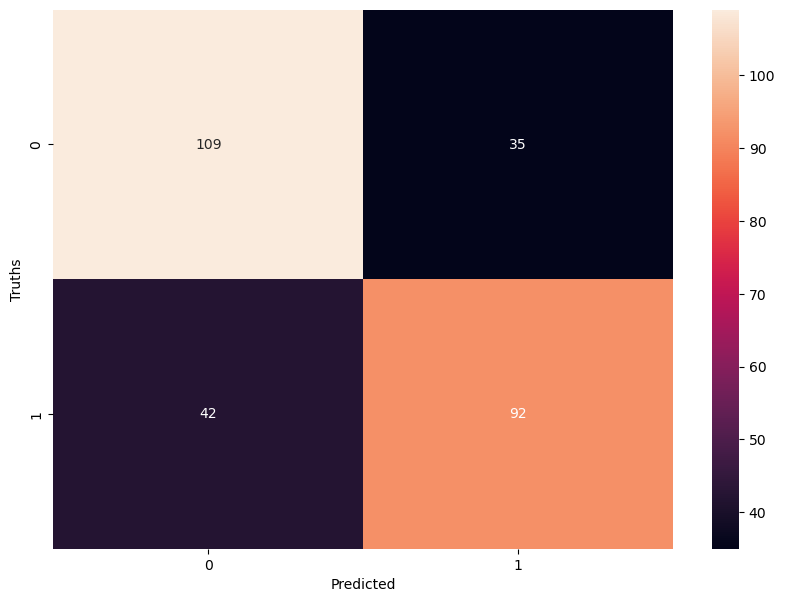

In [14]:
cm = tf.math.confusion_matrix(labels = y_test , predictions= y_pred)
plt.figure(figsize= (10 , 7))
sns.heatmap(cm , annot=True , fmt= 'd')
plt.xlabel("Predicted")
plt.ylabel("Truths")

c:\Users\thoma\anaconda3\envs\conda\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


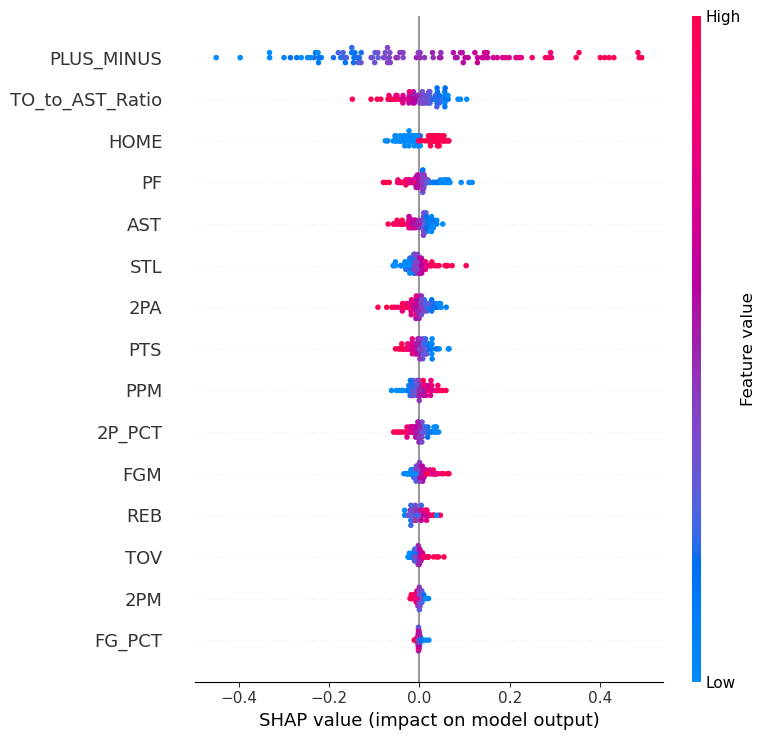

TypeError: Object of type EagerTensor is not JSON serializable

In [15]:
# Ensure feature_names matches the column order in X_train
feature_names = X_train.columns.tolist()



# SHAP Analysis
from tqdm import tqdm
import shap
# Function to make predictions
# Function to make predictions and ensure NumPy array outputs
def model_predict(X):
    return model.predict(X).flatten().astype(float)  # Ensure output is NumPy array


# Ensure X_test is in the correct format
if isinstance(X_test, pd.DataFrame):
    X_test_array = X_test.values  # Convert to NumPy array if it's a DataFrame
else:
    X_test_array = X_test  # Already a NumPy array

# Use all of X_train as background data for SHAP
if isinstance(X_train, pd.DataFrame):
    background_data = X_train.values  # Use all rows, converted to NumPy array
else:
    background_data = X_train 

# Initialize SHAP explainer
explainer = shap.DeepExplainer(model, background_data)

# Ensure all SHAP inputs are NumPy arrays
if isinstance(X_test, pd.DataFrame):
    X_test_array = X_test.values  # Convert DataFrame to NumPy array
else:
    X_test_array = X_test

# Generate SHAP values for all rows in X_test_array[:100]
shap_values = explainer.shap_values(X_test_array[:100])

# If shap_values is a list, extract the first element
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# Reshape SHAP values to remove any extra dimensions
shap_values = shap_values.squeeze()  # Converts shape (100, 28, 1) to (100, 28)

# Visualize SHAP results
shap.summary_plot(shap_values, X_test_array[:100], feature_names=feature_names)

# Ensure NumPy arrays for force plot
shap.force_plot(
    explainer.expected_value[0], 
    shap_values[0], 
    X_test_array[0], 
    feature_names=feature_names
)